**Before Everything:**

For accesssibility to our whole class, we recommend using Google Colab to run the Python code of this homework. It saves versions automatically, provides a GPU for free use, and anyone with a Google account can easily implement it.
- [See a basic tutorial by Google of using Colab](https://colab.research.google.com/?utm_source=scs-index)


For those who have coding background and are more comfortable with other platforms to execute *.ipynb* code files:
- [Kaggle Notebooks](https://www.kaggle.com/code), also provide a (slower) GPU
- [Jupyter Lab](https://jupyter.org/try)
- [Anaconda](https://docs.continuum.io/free/anaconda/install/), run notebooks on your local device. (For Mac Users, please refer to the configuration and commands from official documentation)


cred: Ye Tian 2024


## Data Preparation

**Working via Google Colab only. Please log in and mount your drive**

To run a cell of code, press the image.png button, or press 'Shift+Enter' together on your keyboard. This applies to all remaining cells.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading the provided dataset - please change the 'root_path' variable to your own path where you saved the image folders**

*Hint: On your left side, in the 'Files', you can find and right click the folder, then click 'copy path'*

In [ ]:
import os

root_path = '/content/drive/MyDrive/Module3_HW_OCT_img/'  # CHANGE_TO_YOUR_PATH
disease_folder = root_path + 'DISEASE_OCT_SLICE100'
normal_folder = root_path + 'NORMAL_OCT_SLICE100'

normal_count = len([file for file in os.listdir(normal_folder) if file.endswith('.bmp')])
disease_count = len([file for file in os.listdir(disease_folder) if file.endswith('.bmp')])

print(f"Number of images in 'NORMAL' folder: {normal_count}")
print(f"Number of images in 'DISEASE' folder: {disease_count}")

Number of images in 'NORMAL' folder: 251
Number of images in 'DISEASE' folder: 249


**Import other packages**

In [ ]:
!pip install timm
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torchsummary import summary
import timm
from timm.data import resolve_data_config, create_transform
import random

**Importing some other libraries for image reading**

In [ ]:
import PIL
from PIL import Image
import torch
from torch.utils.data import Dataset
import pandas as pd
import cv2
from PIL import ImageFile
from torchvision import datasets, models, transforms
from torchvision.transforms.transforms import RandomAutocontrast
ImageFile.LOAD_TRUNCATED_IMAGES = True
from pandas.core.base import NoNewAttributesMixin

**Defining the Dataset class, including Cropping and Centering of Images**

Pytorch official tutorial for Dataset and Dataloader classes: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [ ]:

class OCTDataset(torch.utils.data.Dataset):
    def __init__(self, image_path='', label_path='', transform=None):
        """
        2D OCT dataset loader
        :param image_path: path to image folder (DISEASE or NORMAL)
        :param label_path: path to labels file, here we can use just the folder name to define labels
        :param transform: Optional image transforms
        """
        self.transform = transform
        self.img_dir = image_path
        self.image_paths = sorted(os.listdir(self.img_dir))

    def __len__(self):
        return len(self.image_paths)

    def center_crop_or_pad(self, input_img, desired_dimension):
        input_img = np.array(input_img)
        input_dimension = input_img.shape

        x_lowerbound_target = max(int(np.floor((desired_dimension[0] - input_dimension[0]) / 2)), 0)
        y_lowerbound_target = max(int(np.floor((desired_dimension[1] - input_dimension[1]) / 2)), 0)

        x_upperbound_target = None if desired_dimension[0] < input_dimension[0] else x_lowerbound_target + input_dimension[0]
        y_upperbound_target = None if desired_dimension[1] < input_dimension[1] else y_lowerbound_target + input_dimension[1]

        x_lowerbound_input = 0 if desired_dimension[0] >= input_dimension[0] else int(np.floor((input_dimension[0] - desired_dimension[0]) / 2))
        y_lowerbound_input = 0 if desired_dimension[1] >= input_dimension[1] else int(np.floor((input_dimension[1] - desired_dimension[1]) / 2))

        x_upperbound_input = None if desired_dimension[0] >= input_dimension[0] else x_lowerbound_input + desired_dimension[0]
        y_upperbound_input = None if desired_dimension[1] >= input_dimension[1] else y_lowerbound_input + desired_dimension[1]

        output_scan = np.zeros((desired_dimension[0], desired_dimension[1])).astype(np.float32)
        output_scan[x_lowerbound_target:x_upperbound_target, y_lowerbound_target:y_upperbound_target] = input_img[x_lowerbound_input:x_upperbound_input, y_lowerbound_input:y_upperbound_input]

        output_scan = np.stack([output_scan]*3, axis=-1)

        output_img = Image.fromarray(output_scan.astype('uint8'), 'RGB')
        return output_img

    def get_item_with_original(self, idx):
        nm = self.image_paths[idx]

        if 'NORMAL' in self.img_dir:
            label = 0
        else:
            label = 1

        img_path = os.path.join(self.img_dir, nm)
        original_img = PIL.Image.open(img_path)
        transformed_img = self.center_crop_or_pad(original_img, (224, 224))

        if self.transform is not None:
            transformed_img = self.transform(transformed_img)

        return original_img, transformed_img, label

    def __getitem__(self, idx, plot=False):
        nm = self.image_paths[idx]

        if 'NORMAL' in self.img_dir:
            label = 0
            cls = 'healthy'
        else:
            label = 1
            cls = 'disease'

        img_path = os.path.join(self.img_dir, nm)
        img = PIL.Image.open(img_path)

        img = self.center_crop_or_pad(img, (224, 224))

        if self.transform is not None:
            img = self.transform(img)
        label = int(label)

        return img, label


**Your desired transformations of images**

Transformations of images are always one of the most fun part in medical image processing, or computer vision in general.

**- See some interesting example pictures after data augmentation (transformation): https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py**

**- See a full list of transformations you can do using *pytorch.transforms*: https://pytorch.org/vision/0.9/transforms.html. You are able to change the size, color, orientation, contrast, normalization and more of your images, as you wish!**

In [ ]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(kernel_size=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



**Instantiate the datasets using Dataset class defined above**

In [ ]:

datasets = { ## Define the dataset for 'NORMAL' and 'DISEASE' folders
'NORMAL':
 OCTDataset(image_path= root_path + 'DISEASE_OCT_SLICE100',
                                transform=data_transforms['train']),
'DISEASE':
OCTDataset(image_path= root_path + 'NORMAL_OCT_SLICE100',
                                transform=data_transforms['train'])
}

combined_dataset = datasets['NORMAL'] + datasets['DISEASE']


**Showing a random image pair of before-after your transformation**

/tmp/ipython-input-3581571320.py:37: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  output_img = Image.fromarray(output_scan.astype('uint8'), 'RGB')


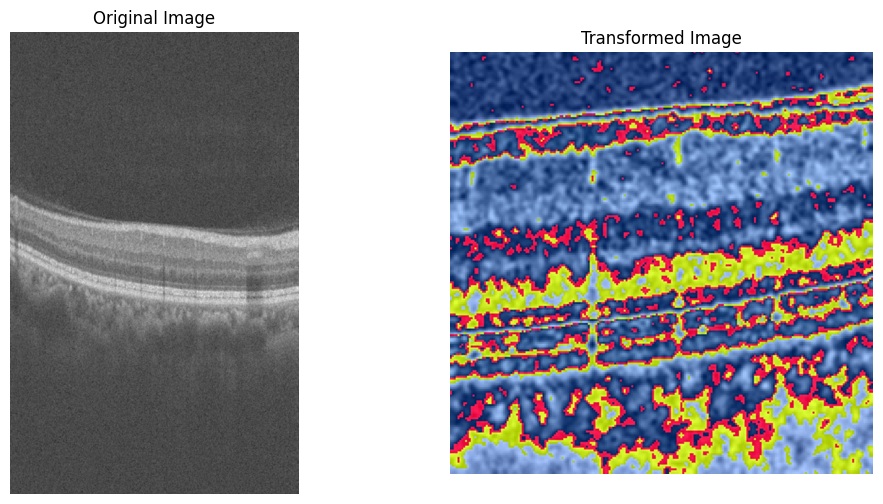

In [ ]:
def show_transformed_images(dataset, idx):
    original, transformed, label = dataset.get_item_with_original(idx)

    original = transforms.ToTensor()(original)
    original = transforms.ToPILImage()(original).convert("RGB")

    transformed = transforms.ToPILImage()(transformed).convert("RGB")

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(transformed)
    axes[1].set_title('Transformed Image')
    axes[1].axis('off')

    plt.show()

show_transformed_images(datasets['NORMAL'], 5) #Please feel free to change the index here, and run this code cell again to see other image examples


In [ ]:
print('Number of images in the combined dataset now: ', len(combined_dataset))

Number of images in the combined dataset now:  500


**Instantiate the train, validation and test dataloaders with a 0.8 : 0.1
: 0.1 ratio**

In [ ]:
from torch.utils.data import DataLoader

train_size = int(0.8 * len(combined_dataset))
val_size = int(0.1 * len(combined_dataset))
test_size = len(combined_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    combined_dataset, [train_size, val_size, test_size]
)

batch_size = 5 #Optional: change the batch size and explore it's effect in following training steps
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {
    'train': train_dataloader,
    'validation': val_dataloader,
    'test': test_dataloader
}


**Check if you are using Google GPU**

In [ ]:
import torch
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


**If your device is not in type of 'cuda', please go to the 'Runtime' at top bars, then click 'Change runtime type', and select 'T4 GPU'**

## Models

**Model Option #1: Hard-coded vision transformer via Pytorch
trained on our dataset from scratch.**

In [ ]:

class VisionTransformer(nn.Module):
    def __init__(self, num_classes=2, image_size=224, patch_size=16, hidden_dim=768, num_heads=12, num_layers=12):
        super(VisionTransformer, self).__init__()

        self.patch_embed = nn.Conv2d(3, hidden_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        num_patches = (image_size // patch_size) ** 2
        self.position_embed = nn.Parameter(torch.randn(1, num_patches + 1, hidden_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.transformer = nn.Transformer(d_model=hidden_dim, nhead=num_heads, num_encoder_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.patch_embed(x)  # (B, hidden_dim, L, L), where L = H // patch_size
        x = x.flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.position_embed

        x = self.transformer(x, x)
        x = x[:, 0, :]  # (B, hidden_dim)
        x = self.fc(x)

        return x

model = VisionTransformer(num_classes=2, image_size=224, patch_size=16).to(device)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


KeyboardInterrupt: 

**Model Option #2: a small 2D Convolutional Neural Network (CNN)**

a tutorial for training your CNN with Pytorch: PyTorch: https://pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/

In [ ]:

class SmallCNN2D(nn.Module):
    def __init__(self, num_classes=2):
        super(SmallCNN2D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  # Adjust the input size to match (3, 224, 224)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the 2D feature map
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x


**Model Option #3: still a CNN, but with deeper layers. Complete the missing lines of code (Question 6).**

The output dimensions after each operation in the forward function is provided in comments.

Note: You will encounter an error in this cell unless the model definition is completed.

In [ ]:

class LargerCNN2D(nn.Module):
    def __init__(self, num_classes=2):
        super(LargerCNN2D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # [Question 6: Your code here]
        # Fill in the remaining lines using the table of descriptions provided in the assignment overview document.
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(28*28*64, 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x): # Input x: (224,224,3)
        x = self.pool1(self.relu1(self.conv1(x))) # (112,112, 16)
        x = self.pool2(self.relu2(self.conv2(x))) # (56, 56, 32)
        x = self.pool3(self.relu3(self.conv3(x))) # (28, 28, 64)
        x = x.view(x.size(0), -1)  # (28*28*64)
        x = self.relu4(self.fc1(x)) # (128)
        x = self.fc2(x) # (num_classes)
        return x




**Model Option #4: a pretrained swin transformer, with pretrained weights on IMAGENET1K**

-Official document from pytorch.torchvision of swin_t: https://pytorch.org/vision/main/models/generated/torchvision.models.swin_t.html

-Original paper for swin transformer published in 2021: https://arxiv.org/abs/2103.14030

In [ ]:

from torchvision.models import swin_t, Swin_T_Weights
class SwinT(nn.Module):
  def __init__(self):
    super(SwinT, self).__init__()
    self.model1 = swin_t(weights=Swin_T_Weights.IMAGENET1K_V1)

    self.fc1 = nn.Linear(1000, 2)

  def forward(self, x):
     x = self.model1(x)
     x = self.fc1(x)
     return x


**Model Option #5: a pretrained vision transformer (based version), via Hugging Face**

-Official Documentation: https://huggingface.co/google/vit-base-patch16-224

-Original paper for vision transformer (ViT): https://arxiv.org/abs/2010.11929


In [ ]:
import timm

class ViTModel(nn.Module):
    def __init__(self, num_classes=2):
        super(ViTModel, self).__init__()
        self.backbone = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.backbone.head = nn.Linear(self.backbone.head.in_features, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        return x


**Model Option #6: a pretrained ResNet-50, with pretrained weights on IMAGENET1K**

-Official document from pytorch.torchvision of ResNets: https://pytorch.org/vision/main/models/resnet.html

-Original paper for ResNet published in 2015:https://arxiv.org/abs/1512.03385

In [ ]:
from torchvision.models import ResNet152_Weights, ResNet50_Weights

class ResNetModel(nn.Module):
    def __init__(self, num_classes=2, resnet_variant=models.resnet50):
        super(ResNetModel, self).__init__()
        self.model1 = resnet_variant(pretrained=True)
        in_features = self.model1.fc.in_features
        self.model1.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.model1(x)
        return x


**To Switch the model you want to use, please uncomment the one you want, comment all other lines, and run the cell again. In this way, the 'model' variable is re-established to your desired model from all model options defined above**

('comment' means adding a '#' in front of your code', 'uncomment' means removing the '#' in front of your code)

In [ ]:
#model, model_name = VisionTransformer().to(device) , 'VisionTransformer'
#model, model_name = SwinT().to(device), 'SwinT'
#model, model_name = SmallCNN2D().to(device), 'SmallCNN2D'
#model, model_name = LargerCNN2D().to(device), 'LargerCNN2D'
model, model_name = ViTModel().to(device), 'ViTModel'
#model, model_name = ResNetModel().to(device), 'ResNetModel'

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

## Training Models and Evaluation

**Specifiying training parameters, loss and optimizer. For simplificity and effectiveness, we are using a constant learning rate and a relatively small number of epochs**

(optional: think about the number of epochs, the learning rate (lr) and optimizer you are using - why do you pick them, and what if you change them? Modify the variables in this cell and see the effect in the following training)


In [ ]:
epochs = 5
lr = 1e-5

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, nesterov=True, lr=lr, weight_decay=0.)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

**Training function and execution**

If you find your training is latent, such as stuck at epoch 0 for over 5 minutes, please confirm if you are **using GPU** runtime.

In [ ]:

import time
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, save_dir=root_path):
    since = time.time()
    best_acc = 0.0
    best_f1 = 0.0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_aucs = []
    val_aucs = []
    train_f1s = []
    val_f1s = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            all_labels = []
            all_preds = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                   # print(inputs.shape) = [batch size,3,224,224]
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_acc = epoch_acc.cpu().item()  # Convert to a Python scalar

            epoch_auc = roc_auc_score(all_labels, all_preds)
            epoch_f1 = f1_score(all_labels, all_preds)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
                train_aucs.append(epoch_auc)
                train_f1s.append(epoch_f1)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
                val_aucs.append(epoch_auc)
                val_f1s.append(epoch_f1)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC: {epoch_auc:.4f} F1: {epoch_f1:.4f}')

            if phase == 'validation' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    #print(f'Best validation accuracy: {best_acc:.4f}')

    if save_dir:
        model.load_state_dict(best_model_wts)
        model_save_path = os.path.join(save_dir, model_name + '_' + 'best_model.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f'Model weights saved at: {model_save_path}')

    model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, train_accuracies, val_accuracies, train_aucs, val_aucs, train_f1s, val_f1s

epochs = 10
save_directory = root_path

model, train_losses, val_losses, train_accuracies, val_accuracies, train_aucs, val_aucs, train_f1s, val_f1s = train_model(model, dataloaders, criterion, optimizer, epochs, save_directory)


Epoch 1/10
----------


/tmp/ipython-input-3581571320.py:37: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  output_img = Image.fromarray(output_scan.astype('uint8'), 'RGB')


train Loss: 0.6196 Acc: 0.6875 AUC: 0.6875 F1: 0.6898


/tmp/ipython-input-3581571320.py:37: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  output_img = Image.fromarray(output_scan.astype('uint8'), 'RGB')


validation Loss: 0.6501 Acc: 0.6600 AUC: 0.6600 F1: 0.4848
Epoch 2/10
----------


/tmp/ipython-input-3581571320.py:37: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  output_img = Image.fromarray(output_scan.astype('uint8'), 'RGB')


train Loss: 0.6005 Acc: 0.6800 AUC: 0.6800 F1: 0.6718


/tmp/ipython-input-3581571320.py:37: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  output_img = Image.fromarray(output_scan.astype('uint8'), 'RGB')


validation Loss: 0.4867 Acc: 0.8000 AUC: 0.8000 F1: 0.8148
Epoch 3/10
----------


/tmp/ipython-input-3581571320.py:37: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  output_img = Image.fromarray(output_scan.astype('uint8'), 'RGB')


train Loss: 0.5045 Acc: 0.7725 AUC: 0.7725 F1: 0.7673


/tmp/ipython-input-3581571320.py:37: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  output_img = Image.fromarray(output_scan.astype('uint8'), 'RGB')


validation Loss: 0.4719 Acc: 0.7200 AUC: 0.7200 F1: 0.6316
Epoch 4/10
----------


/tmp/ipython-input-3581571320.py:37: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  output_img = Image.fromarray(output_scan.astype('uint8'), 'RGB')


train Loss: 0.5317 Acc: 0.7125 AUC: 0.7125 F1: 0.6966


/tmp/ipython-input-3581571320.py:37: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  output_img = Image.fromarray(output_scan.astype('uint8'), 'RGB')


validation Loss: 0.4711 Acc: 0.8000 AUC: 0.8000 F1: 0.8333
Epoch 5/10
----------


/tmp/ipython-input-3581571320.py:37: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  output_img = Image.fromarray(output_scan.astype('uint8'), 'RGB')


train Loss: 0.4723 Acc: 0.7675 AUC: 0.7675 F1: 0.7493


/tmp/ipython-input-3581571320.py:37: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  output_img = Image.fromarray(output_scan.astype('uint8'), 'RGB')


validation Loss: 0.4766 Acc: 0.8600 AUC: 0.8600 F1: 0.8772
Epoch 6/10
----------


/tmp/ipython-input-3581571320.py:37: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  output_img = Image.fromarray(output_scan.astype('uint8'), 'RGB')


train Loss: 0.4767 Acc: 0.7650 AUC: 0.7650 F1: 0.7577


/tmp/ipython-input-3581571320.py:37: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  output_img = Image.fromarray(output_scan.astype('uint8'), 'RGB')


validation Loss: 0.4645 Acc: 0.8000 AUC: 0.8000 F1: 0.8276
Epoch 7/10
----------


/tmp/ipython-input-3581571320.py:37: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  output_img = Image.fromarray(output_scan.astype('uint8'), 'RGB')


train Loss: 0.4600 Acc: 0.7675 AUC: 0.7675 F1: 0.7584


/tmp/ipython-input-3581571320.py:37: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  output_img = Image.fromarray(output_scan.astype('uint8'), 'RGB')


validation Loss: 0.3632 Acc: 0.8800 AUC: 0.8800 F1: 0.8889
Epoch 8/10
----------


/tmp/ipython-input-3581571320.py:37: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  output_img = Image.fromarray(output_scan.astype('uint8'), 'RGB')


train Loss: 0.4249 Acc: 0.7975 AUC: 0.7975 F1: 0.7907


/tmp/ipython-input-3581571320.py:37: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  output_img = Image.fromarray(output_scan.astype('uint8'), 'RGB')


validation Loss: 0.3365 Acc: 0.8400 AUC: 0.8400 F1: 0.8519
Epoch 9/10
----------


/tmp/ipython-input-3581571320.py:37: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  output_img = Image.fromarray(output_scan.astype('uint8'), 'RGB')


train Loss: 0.3761 Acc: 0.8275 AUC: 0.8275 F1: 0.8198


/tmp/ipython-input-3581571320.py:37: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  output_img = Image.fromarray(output_scan.astype('uint8'), 'RGB')


validation Loss: 0.3379 Acc: 0.8400 AUC: 0.8400 F1: 0.8462
Epoch 10/10
----------


/tmp/ipython-input-3581571320.py:37: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  output_img = Image.fromarray(output_scan.astype('uint8'), 'RGB')


train Loss: 0.4083 Acc: 0.8125 AUC: 0.8125 F1: 0.8111


/tmp/ipython-input-3581571320.py:37: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  output_img = Image.fromarray(output_scan.astype('uint8'), 'RGB')


validation Loss: 0.4304 Acc: 0.7800 AUC: 0.7800 F1: 0.7925
Training complete in 6m 46s
Model weights saved at: /content/drive/MyDrive/Module3_HW_OCT_img/ViTModel_best_model.pth


**After finishing training (and validation at the same time), plot the loss, accuracy, Area under Curve (AUC), F1-Score curves per epoch**

The definitions are explained in lecture slides. For more information:

-[AUC explained](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

-[f1-score explained](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) (sklearn official)

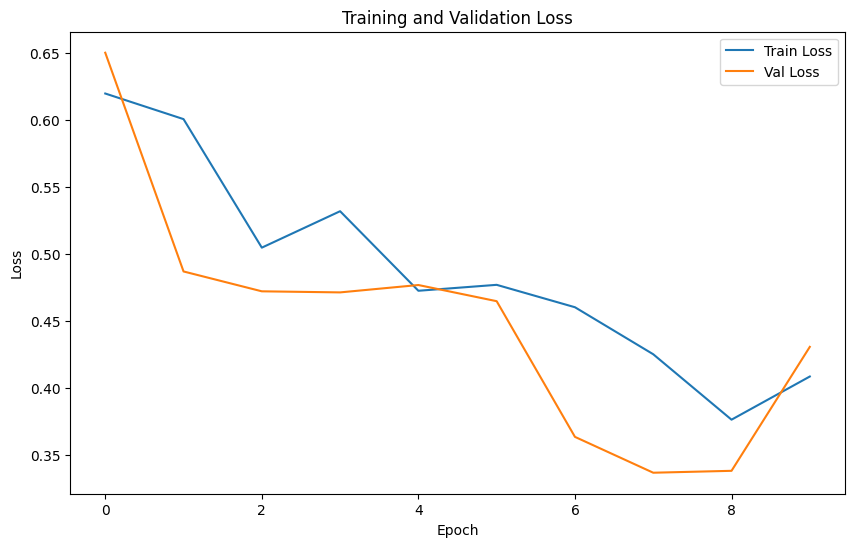

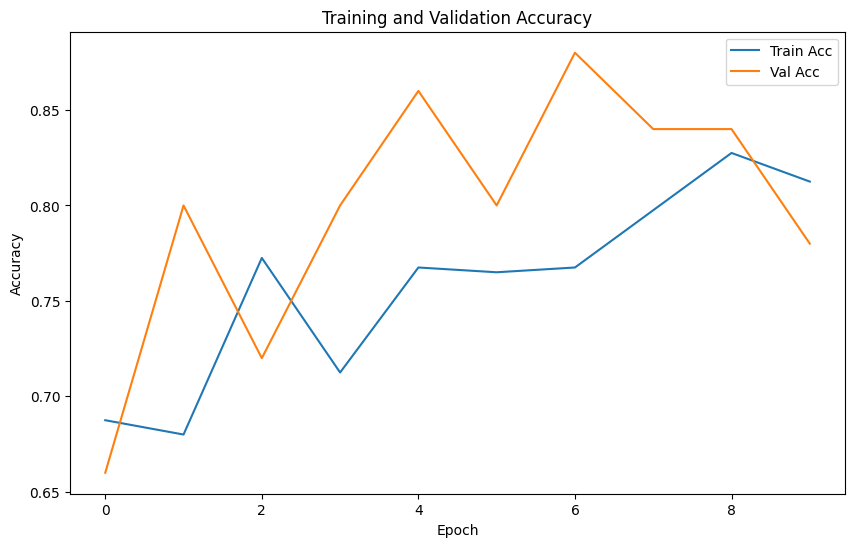

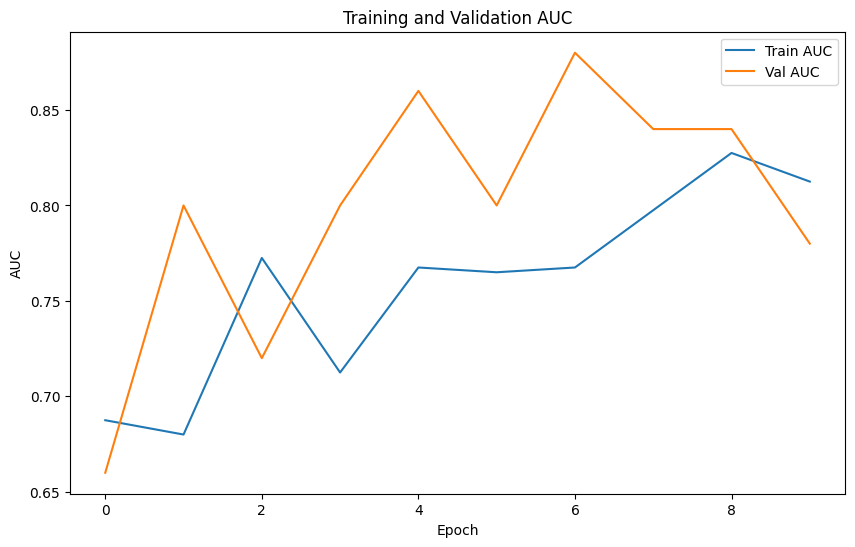

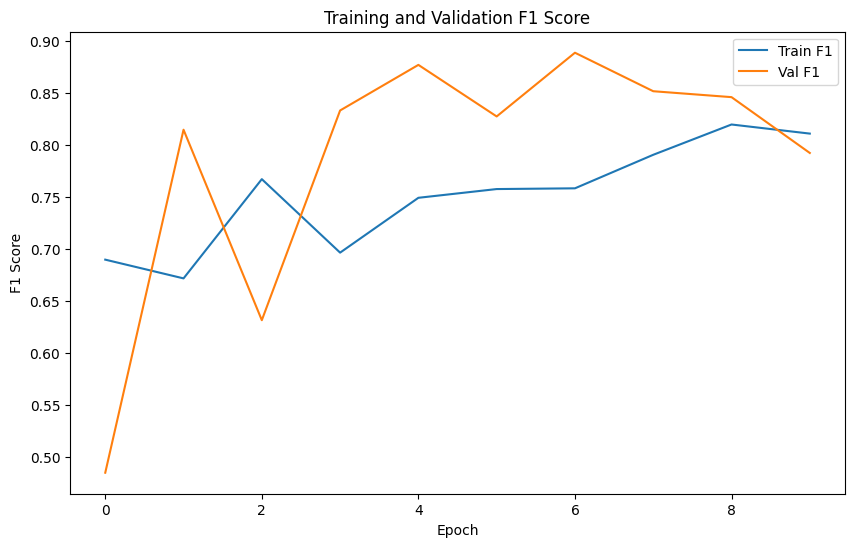

In [ ]:
    plt.figure(figsize=(10, 6))
    plt.title('Training and Validation Loss')
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.title('Training and Validation Accuracy')
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.title('Training and Validation AUC')
    plt.plot(train_aucs, label='Train AUC')
    plt.plot(val_aucs, label='Val AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.title('Training and Validation F1 Score')
    plt.plot(train_f1s, label='Train F1')
    plt.plot(val_f1s, label='Val F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()

In [ ]:
print(model)

ViTModel(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (ac

**One final step! Now we've finished training and validation. We use our pre-defined test set to get the testing performance of our trained model!**

In [ ]:
def test_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / len(dataloader.dataset)
    test_acc = running_corrects.double() / len(dataloader.dataset)
    test_acc = test_acc.cpu().item()  # Convert to a Python scalar

    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')


In [ ]:
test_model(model, test_dataloader, criterion)

/tmp/ipython-input-3581571320.py:37: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  output_img = Image.fromarray(output_scan.astype('uint8'), 'RGB')


Test Loss: 0.4679 Acc: 0.8400


**What's actually happening inside the model? What are the interesting areas of an OCT image recognized by our model?**

**We pick one of our best-performing models, pretrained vision transformer (based version via [HuggingFace](https://huggingface.co/google/vit-base-patch16-224)), to visualize attention rollouts**.

What is 'attention' in a vision transformer? https://medium.com/@jduodu5/attention-mechanism-and-vision-transformer-8955f93c53d2

Note: The cells below will only work after you have run the ViTModel above first!


**Load the saved ViT model path**

In [ ]:
model_path = root_path + 'ViTModel_best_model.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

**To visualize different images, please change the image path at the line start with 'img = Image.open(...)'**


Prediction:  [0]
Image:  /content/drive/MyDrive/Module3_HW_OCT_img/NORMAL_OCT_SLICE100/10026.bmp
Prediction is healthy, groud truth is healthy, this is a True Negative (TN)
torch.Size([14, 14])


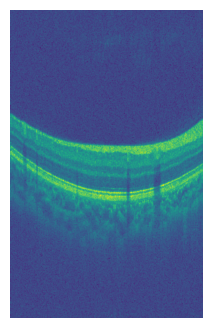

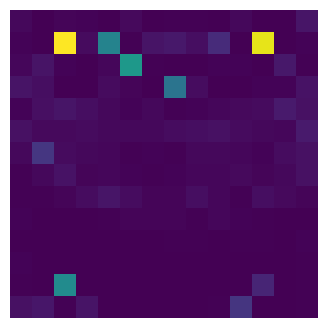

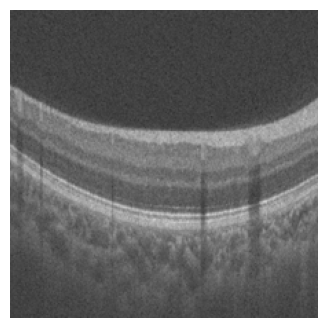

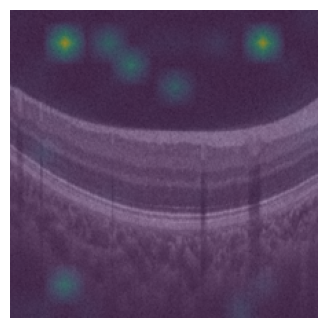

In [ ]:
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, ToTensor

def to_tensor(img):
    if img.mode == 'L':
        img = img.convert('RGB')

    transform_fn = Compose([Resize(249, 3), CenterCrop(224), ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    return transform_fn(img)

def show_img(img):
    img = np.asarray(img)
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def show_img2(img1, img2, alpha=0.8):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    plt.figure(figsize=(4, 4))
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha)
    plt.axis('off')
    plt.show()

def my_forward_wrapper(attn_obj):
    def my_forward(x, attn_mask=None):
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 1:]  # dims: batch, head, ntokens, ntokens

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward

image_path = root_path + 'NORMAL_OCT_SLICE100/10026.bmp'
img = Image.open(image_path) ##Change to any other image you want!
x = to_tensor(img)

model.backbone.blocks[-1].attn.forward = my_forward_wrapper(model.backbone.blocks[-1].attn)

x = x.to(device)
model = model.to(device)

x = x.unsqueeze(0) #x.shape = torch.Size([1, 3, 224, 224])
y = model(x)
_, preds = torch.max(y, 1)
print('Prediction: ', preds.cpu().numpy()) # 1 = disease, 0 = healthy
print('Image: ', image_path)
if preds.cpu().numpy() == 1:
  if 'DISEASE' in image_path:
    print('Prediction is disease, groud truth is disease, this is a True Positive (TP)')
  else:
    print('Prediction is disease, groud truth is healthy, this is a False Positive (FP)')

if preds.cpu().numpy() == 0:
  if 'DISEASE' in image_path:
    print('Prediction is healthy, groud truth is disease, this is a False Negative (FN)')
  else:
    print('Prediction is healthy, groud truth is healthy, this is a True Negative (TN)')

attn_map = model.backbone.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = model.backbone.blocks[-1].attn.cls_attn_map.mean(dim=1).view(14, 14).detach()
print(cls_weight.size())  # check the size

x = x.squeeze()
img_resized = x.permute(1, 2, 0) * 0.5 + 0.5

cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)

show_img(img)
show_img(cls_weight.cpu())
show_img(img_resized.cpu())
show_img2(img_resized.cpu(), cls_resized.cpu(), alpha=0.4) # value of 0.8 for alpha means that attention will be 20% transparent, allowing image to show through